# Pharma Drug Reviews

Below is a walk through of how we go about 
* Reading in the review data
* Transforming the reviews from a 1-10 scale, to an NPS scale
* Cleaning the drugName & conditions
* Cleaning and tokenizing the reviews

_Going from a 1-10 scale to an NPS scale is benefitial because NPS is an industry metric that's simpler for communication purposes (i.e detractor, neutral, promoter), and I don't believe there to be much differene between a 5-rating and a 6-rating...both of these signal the same thing. For modeling, it'll be simpler to use our training data to learn patterns to predict 3-classes instead of 10._

###  Import Modules /  Packages

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.display.max_columns = 10

# constants
import settings
# import UDFs
from utils import *

import matplotlib.pyplot as plt

# style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Read in Data

In [2]:
# Read in Raw Data
data = pd.read_csv(
    os.path.join(settings.DATA_DIR_RAW, settings.TRAIN_RAW),
    sep='\t',
)

# columns of interest
columns = [
    "drugName",
    "condition",
    "review",
    "rating",
]

data = data[columns]
data.head()

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   drugName   161297 non-null  object 
 1   condition  160398 non-null  object 
 2   review     161297 non-null  object 
 3   rating     161297 non-null  float64
dtypes: float64(1), object(3)
memory usage: 4.9+ MB


### Ratings Distribution

In [4]:
print('Ratings')

ratings_summary = pd.concat(
    [
        data['rating'].value_counts(normalize=False).rename('count'), 
        data['rating'].value_counts(normalize=True).rename('pct'),
    ], 
    axis=1
).sort_index()

ratings_summary

Ratings


,count,pct
1.0,21619,0.134032
2.0,6931,0.042970
3.0,6513,0.040379
4.0,5012,0.031073
5.0,8013,0.049679
6.0,6343,0.039325
7.0,9456,0.058625
8.0,18890,0.117113
9.0,27531,0.170685
10.0,50989,0.316119


Makes more sense to predict something like `NPS Rating` (standard industry metric)

```
 -----------------------
| NPS Score |   Rating  |
|-----------|-----------|
|    -1     |   1 - 6   |
|-----------|-----------|
|     0     |   7 - 8   |
|-----------|-----------|
|    +1     |   9 - 10  |
 -----------------------
```


In [5]:
data['nps_rating'] = data['rating'].apply(nps_transformation)

print('NPS Ratings')

nps_summary = pd.concat(
    [
        data['nps_rating'].value_counts(normalize=False).rename('count'), 
        data['nps_rating'].value_counts(normalize=True).rename('pct'),
    ], 
    axis=1
).sort_index()

nps_summary

NPS Ratings


,count,pct
-1,54431,0.337458
0,28346,0.175738
1,78520,0.486804


### Plot Ratings

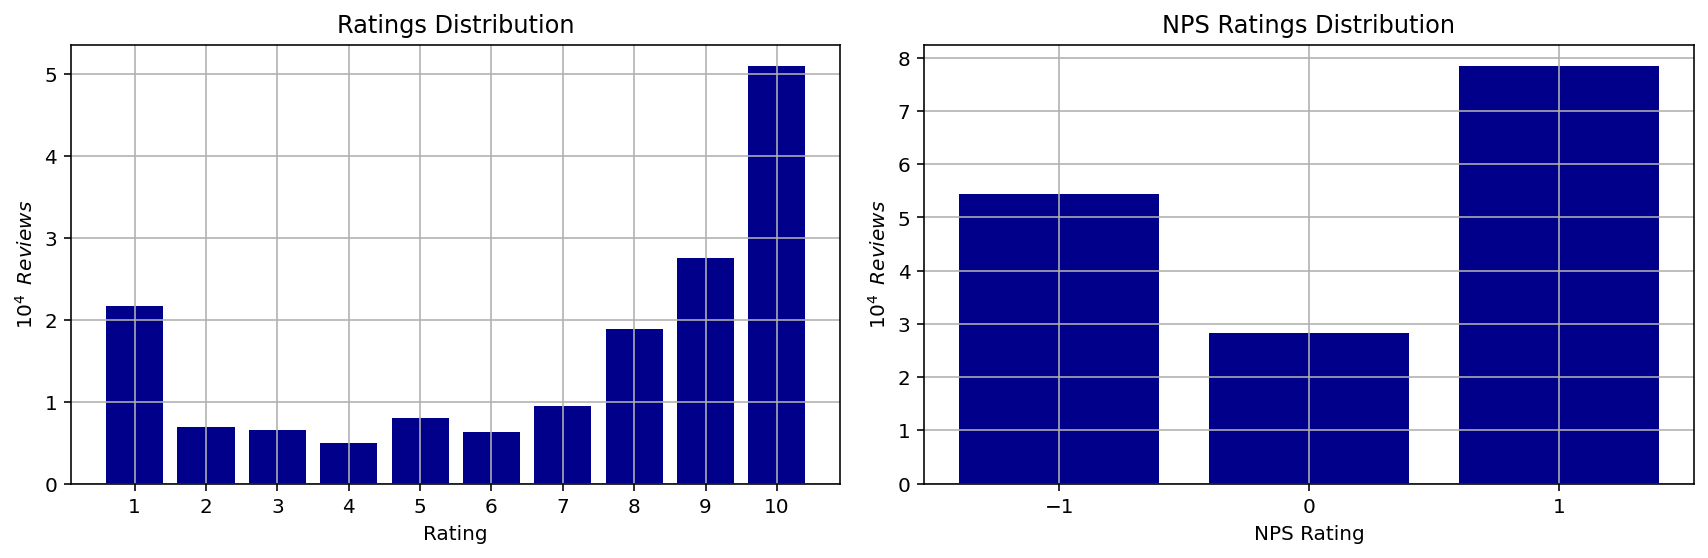

In [6]:
fig, ax  = plt.subplots(1,2, figsize=(12,4))

ax[0].bar(
    x=ratings_summary.index, 
    height=ratings_summary['count'].values / 10_000,
    color='darkblue',
)

ax[0].set_xticks(ratings_summary.index)
ax[0].set_xlabel('Rating')
ax[0].set_ylabel(r'$10^{4}\;\:Reviews$')
ax[0].set_title('Ratings Distribution')
ax[0].grid()

ax[1].bar(
    x=nps_summary.index, 
    height=nps_summary['count'].values / 10_000,
    color='darkblue',
)

ax[1].set_xticks(nps_summary.index)
ax[1].set_xlabel('NPS Rating')
ax[1].set_ylabel(r'$10^{4}\;\:Reviews$')
ax[1].set_title('NPS Ratings Distribution')
ax[1].grid()

plt.tight_layout()
plt.show()

### Clean Conditions & Drug Names

_Conditions: Some of which are NaN, others are clearly resulting from data collection errors_

_Drugs: Just need to remove non-characters_

In [7]:
condition_error = 'found this comment helpful'
mask = data['condition'].apply(lambda c: (pd.isnull(c) or (condition_error in c) or (len(c) < 4)))

print('Error Conditions')
data.loc[mask, 'condition'].sample(5, random_state=settings.RAND_STATE)

Error Conditions


60725     23</span> users found this comment helpful.
4509                                              NaN
154000                                            Gas
34030      0</span> users found this comment helpful.
91979                                             NaN
Name: condition, dtype: object

In [8]:
default_condition = 'Condition Unknown'

# Use default_condition as a replacement when applicable
f = lambda cond: \
    default_condition if \
    (pd.isnull(cond) or (condition_error in cond) or (len(cond) < 4)) \
    else cond

# Apply the above lambda func & remove non characters
data['condition'] = data['condition'].apply(f).apply(remove_non_characters)

# Remove non-characters from drugName
data['drugName'] = data['drugName'].apply(remove_non_characters)

### Sample Data

In [9]:
sample_data = data.sample(100).reset_index(drop=True)
sample_data.head()

,drugName,condition,review,rating,nps_rating
0,Prempro,Postmenopausal Symptoms,"""I had a heavy painful period and was clotty. ...",2.0,-1
1,Desogestrel ethinyl estradiol,Birth Control,"""Apri made me sick to my stomach everyday and ...",1.0,-1
2,Ethinyl estradiol levonorgestrel,Condition Unknown,"""I&#039;ve been taking Alesse during my course...",10.0,1
3,Varenicline,Smoking Cessation,"""I was up to 1 1/2 - 2 large packs of cigarett...",10.0,1
4,Yaz,Acne,"""I&#039;m 19 years old, and I&#039;ve been tak...",4.0,-1


### Pre-Process Drug Reviews

In [10]:
# SUMMARIZE RAW REVIEW (LENGTH, STOP WORDS, UPPERCASE WORDS)
sample_data['review_length'] = sample_data['review'].apply(get_document_length)
sample_data['stop_words'] = sample_data['review'].apply(get_num_stop_words)
sample_data['uppercase_words'] = sample_data['review'].apply(count_uppercase_words)

# CREATE CLEAN_REVIEW COLUMN
sample_data['clean_review'] = sample_data['review']

# CLEAN REVIEW (REMOVE STOP WORDS, EMAILS, DATES, ETC...)
sample_data['clean_review'] = sample_data['clean_review'].apply(clean_document)

### Print Sample(s)

In [11]:
masked_index = sample_data.sample(2, random_state=settings.RAND_STATE).index

def summarize_review(review, drug, condition, rating, clean_review):
    idx = masked_index[0]
    print('Drug: {}'.format(drug))
    print('Condition: {}'.format(condition))
    print('\nReview (Rating: {})'.format(int(rating)))
    print(len('Review')*'-')
    print(review)
    print('\nClean Review')
    print(len('Clean Review')*'-')
    print(clean_review)
    print('\nClean Review Tokens')
    print(len('Clean Review Tokens')*'-')
    print(np.array(clean_review.split()))

In [12]:
idx = masked_index[0]

summarize_review(
    review = sample_data.loc[idx, 'review'], 
    drug = sample_data.loc[idx, 'drugName'], 
    condition = sample_data.loc[idx, 'condition'], 
    rating = sample_data.loc[idx, 'rating'],
    clean_review = sample_data.loc[idx, 'clean_review'],
)

Drug: Gabapentin
Condition: Restless Legs Syndrome

Review (Rating: 9)
------
"This medicine has been life changing! I was always told my rls is in my head and not real. It&#039;s just me being worried or nervous. Thankfully, I asked my dr. She told me, it&#039;s very real and asked my symptoms. They matched perfectly with all rls symptoms. I take Gabapentin before bed. It takes about 30 minutes to kick in, but when it does, I&#039;m able to relax and sleep. When I get out of bed in the morning, my legs don&#039;t ache because I&#039;m no longer moving them all night. Please seek medical help if you are struggling with rls. This medicine might not be for you, but whatever medicine works is worth it!!"

Clean Review
------------
this medicine been life changing always told head real just being worried nervous thankfully asked told very real asked symptoms they matched perfectly with symptoms take gabapentin before takes about minutes kick when does able relax sleep when morning legs ach

In [13]:
idx = masked_index[1]

summarize_review(
    review = sample_data.loc[idx, 'review'], 
    drug = sample_data.loc[idx, 'drugName'], 
    condition = sample_data.loc[idx, 'condition'],
    rating = sample_data.loc[idx, 'rating'],
    clean_review = sample_data.loc[idx, 'clean_review'],
)

Drug: Ethinyl estradiol norgestrel
Condition: Birth Control

Review (Rating: 7)
------
"I have tried a few types of birth control pills before this, but Lo/Ovral has been very effective as far as period control is concerned.  I usually skip the week of placebos and jump straight into the next pack to avoid having periods altogether, and this is the only birth control pill that doesn&#039;t cause breakthrough bleeding as a result. It has been an effective contraceptive."

Clean Review
------------
have tried types birth control pills before this ovral been very effective period control concerned usually skip week placebos jump straight into next pack avoid having periods altogether this only birth control pill that doesn cause breakthrough bleeding result been effective contraceptive

Clean Review Tokens
-------------------
['have' 'tried' 'types' 'birth' 'control' 'pills' 'before' 'this' 'ovral'
 'been' 'very' 'effective' 'period' 'control' 'concerned' 'usually' 'skip'
 'week' 'placebo